# Packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import pickle
import math
import time
import random
import sys
import itertools
import os
import multiprocessing as mp

import scipy
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import ndtri
from scipy.stats import pearsonr as R
from scipy.optimize import linear_sum_assignment

import sklearn
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
import sklearn.decomposition as decomposition

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.utils.extmath import randomized_svd

from tqdm.notebook import tqdm
from IPython.display import clear_output


import matplotlib.pyplot as plt
import seaborn as sns
from visualize_connectome import plot_connectome

import statsmodels
from statsmodels.stats.mediation import Mediation
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats import multitest

# Data

In [2]:
# load in all modalities and data
data = pickle.load(open("/nfs/turbo/ivytso-lab/fMRI/SchizGaze2_16/Saige_Tristan_SG_Collab/SZG_rest_pheno_data.pickle", "rb"))

In [3]:
edges_rest = data['rest_edges']
phen_df = data['phen_df']

In [65]:
# get covariates for all modalities
covars = {
    'rest': np.hstack((
        pd.get_dummies(phen_df['Gender'], drop_first=True).values.reshape(-1,1),
        phen_df.Age.values.reshape(-1,1),
        phen_df.Age2.values.reshape(-1,1),
        phen_df.meanFD_rest.values.reshape(-1,1),
        phen_df.meanFD2_rest.values.reshape(-1,1),
        phen_df.Antipsychotics.values.reshape(-1,1),
        phen_df.MoodStabilizers.values.reshape(-1,1),
        phen_df.Antidepressants.values.reshape(-1,1),
        phen_df.Benzos.values.reshape(-1,1),
        phen_df.Stimulants.values.reshape(-1,1)
        pd.get_dummies(phen_df.study, drop_first=True).values,
        phen_df.group.values.reshape(-1,1)
    ))
}

# get edges into same dictionary
edges = {
    'rest': edges_rest
}

# define variabls of interest and test indices
vars_of_interest = ['MSCEIT_SS_TOT', 'gaze_width', 'thres_alpha']

# define test indices to be used for all analyses
N = edges['rest'].shape[0]
all_idxs = np.arange(N)
n_cv_outer = 10
np.random.seed(123)
test_idxs = np.array_split(np.random.choice(all_idxs, N, replace=False), n_cv_outer)

# Define 10-Fold CV Loop

In [66]:
def Kerby2(X_input, y_input, covars_input, train_idx, method="ols", penalties=None):
    X_covars = np.hstack((X_input, covars_input))
    if method == 'ols':
        ols = LinearRegression().fit(X_covars[train_idx, :], y_input[train_idx])
        y_cc = y_input - ols.intercept_ - covars_input @ ols.coef_[-covars_input.shape[1]:]
        y_pred = X_input @ ols.coef_[:X_input.shape[1]]
        return y_cc, y_pred

In [67]:
# record metrics
metrics = {}
for var in vars_of_interest:
    metrics[f'{var}_R'] = np.zeros((n_cv_outer, 2))
    metrics[f'{var}_MSE'] = np.zeros((n_cv_outer, 2))
    metrics[f'{var}_R2'] = np.zeros((n_cv_outer, 2))
    metrics[f'{var}_EV'] = np.zeros((n_cv_outer, 2))

In [68]:
# define hyperparams
pca_vec = np.arange(1, 81, 5)
n_edges = edges['rest'].shape[1]
n_pc = 11

# define penalty vector so covariates aren't penalized
# don't penalize covariates
penalty_vec = np.zeros((1, pca_vec[-1] + covars['rest'].shape[1]))
penalty_vec[0, :n_edges] = 1

# now let's set up the cross-validation loop
for fold_i in tqdm(range(n_cv_outer), desc='Outer-CV'):
    # get train, test
    test_idx = test_idxs[fold_i]
    train_idx = [x for x in all_idxs if x not in test_idx]
    np.random.seed(fold_i*42)

    # now redo the with correct PCs
    X_pca = decomposition.PCA(n_components=n_pc, random_state=42).fit(edges['rest'][train_idx, :]).transform(edges['rest'])
    for var_i, var in enumerate(tqdm(vars_of_interest, desc='Variables of Interest', leave=False)):
        y = phen_df[var].values.flatten().astype(np.float64)
        # now do kerby2 and get loss metrics
        X_covars = np.hstack((X_pca[:, :n_pc], covars['rest']))
        ols = LinearRegression().fit(X_covars[train_idx,:], y[train_idx])
        y_cc = y - ols.intercept_ - covars['rest'] @ ols.coef_[-covars['rest'].shape[1]:]
        y_pred = X_pca[:, :n_pc] @ ols.coef_[:n_pc]
         
        metrics[f'{var}_R'][fold_i, 0] = R(y_cc[train_idx], y_pred[train_idx])[0]
        metrics[f'{var}_R'][fold_i, 1] = R(y_cc[test_idx], y_pred[test_idx])[0]
        metrics[f'{var}_R2'][fold_i, 0] = r2_score(y_cc[train_idx], y_pred[train_idx])
        metrics[f'{var}_R2'][fold_i, 1] = r2_score(y_cc[test_idx], y_pred[test_idx])
        metrics[f'{var}_EV'][fold_i, 0] = explained_variance_score(y_cc[train_idx], y_pred[train_idx])
        metrics[f'{var}_EV'][fold_i, 1] = explained_variance_score(y_cc[test_idx], y_pred[test_idx])
        metrics[f'{var}_MSE'][fold_i, 0] = MSE(y_cc[train_idx], y_pred[train_idx])
        metrics[f'{var}_MSE'][fold_i, 1] = MSE(y_cc[test_idx], y_pred[test_idx])

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
pickle.dump(metrics, open("/nfs/turbo/ivytso-lab/fMRI/SchizGaze2_16/Saige_Tristan_SG_Collab/SZG_CV_Metrics_final.pickle", "wb"))

# Plot Consensus Per Variable Per Modality

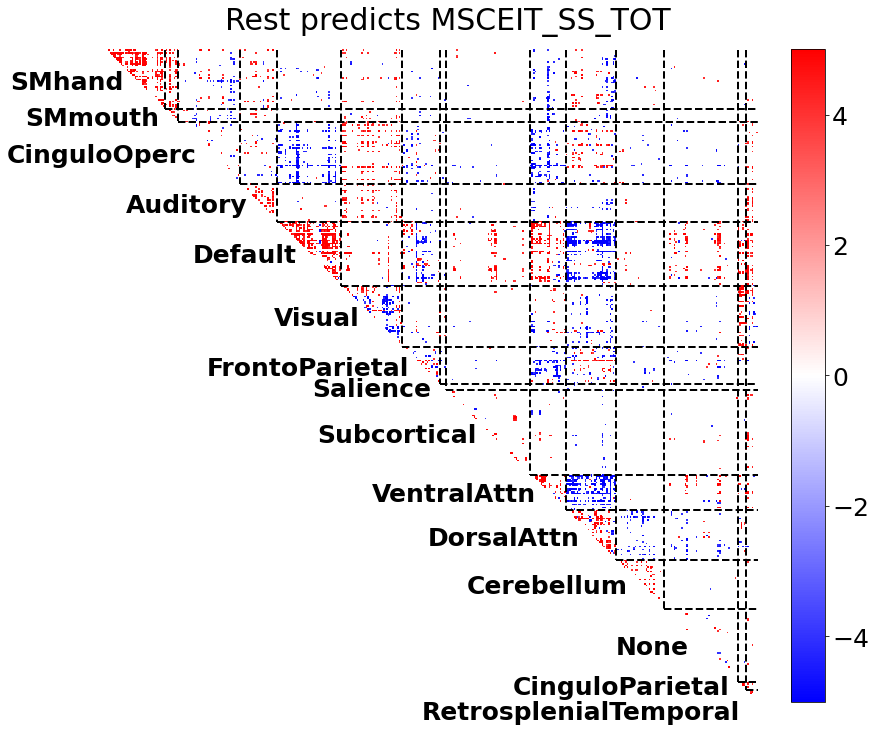

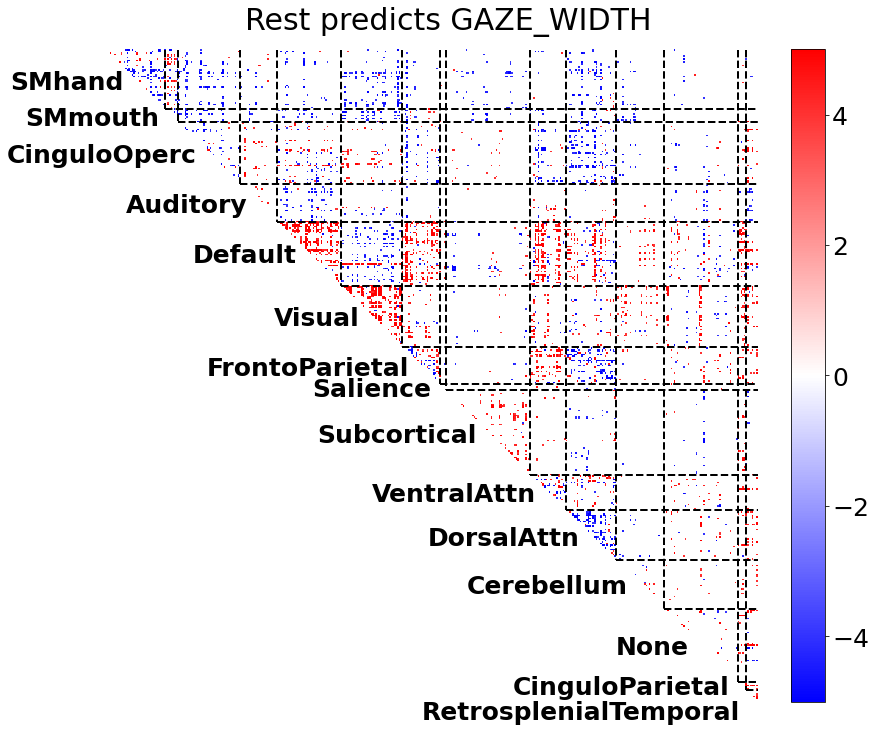

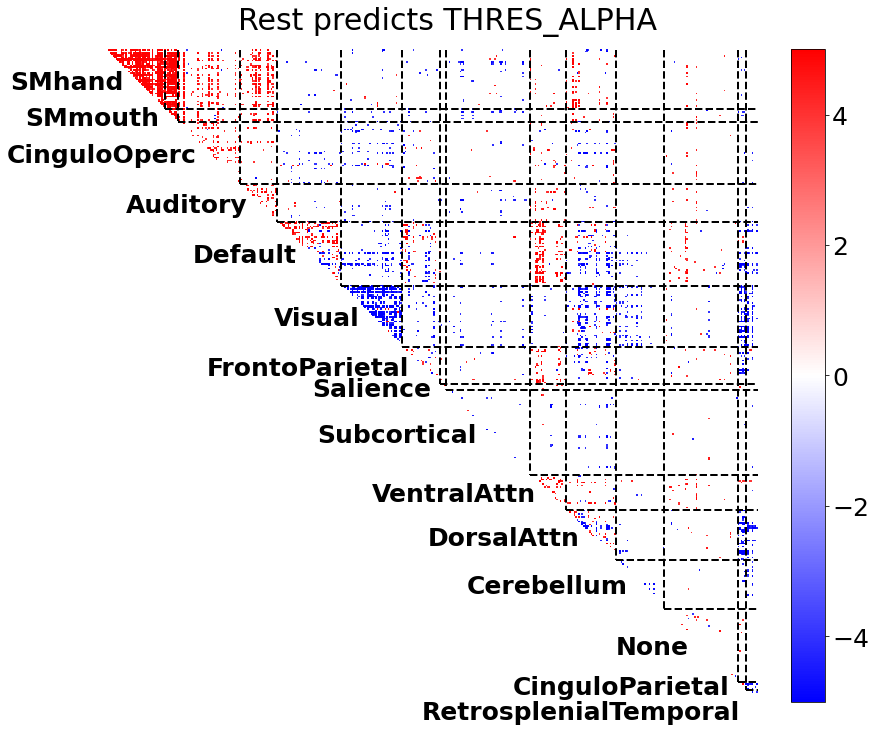

In [27]:
# define options
utri_idxs = np.triu_indices(418, k=1)

# plot the consensus
for var_i, var in enumerate(vars_of_interest):
    # get variable of interest
    y = phen_df[var].values.flatten()
    # fit the PCA
    pca = decomposition.PCA(n_components = n_pc, random_state=42).fit(edges['rest'])
    X_pca = pca.transform(edges['rest'])
        
    # fit the ols
    X_covars = np.hstack((X_pca, covars['rest']))
    ols = LinearRegression().fit(X_covars, y)
        
    # get the consensus, square it, and plot
    con = pca.components_.T @ ols.coef_[:n_pc]
    con = scipy.stats.zscore(con)
    con[np.abs(con) < 1.96] = 0
    con_mat = np.zeros((418, 418))
    con_mat[utri_idxs] = con
    con_mat += con_mat.T
        
    plt.figure(figsize=(14, 12))
    plot_connectome(con_mat, title=f"Rest predicts {var.upper()}", default_range=(-5,5))
    plt.show()

# Permutations Using MSE

    - MSE is used in our permutations because Kerby2 with small sample sizes results in positively biased distributions of correlations

In [17]:
from sklearn.utils import shuffle

n_perms = 10000

# record metrics
perm_metrics = {}
for var in vars_of_interest:
    perm_metrics[f'{var}_R'] = np.zeros((n_perms, n_cv_outer, 2))
    perm_metrics[f'{var}_R2'] = np.zeros((n_perms, n_cv_outer, 2))
    perm_metrics[f'{var}_EV'] = np.zeros((n_perms, n_cv_outer, 2))
    perm_metrics[f'{var}_MSE'] = np.zeros((n_perms, n_cv_outer, 2))

for perm in tqdm(range(n_perms), desc='Permutations'):
    random_state_perm = np.random.RandomState(perm)

    for fold_i in tqdm(range(n_cv_outer), desc='Outer-CV'):
        # get train, test
        test_idx = test_idxs[fold_i]
        train_idx = [x for x in all_idxs if x not in test_idx]
        np.random.seed(fold_i*42)

        # now redo the with correct PCs
        X_pca = decomposition.PCA(n_components=n_pc, random_state=42).fit(edges['rest'][train_idx, :]).transform(edges['rest'])
        for var_i, var in enumerate(tqdm(vars_of_interest, desc='Variables of Interest', leave=False)):
            # now do kerby2 and get loss metrics
            y = phen_df[var].values.flatten().astype(np.float64)
            phen_shuff = shuffle(y, random_state=random_state_perm)

            X_covars = np.hstack((X_pca[:, :n_pc], covars['rest']))
            ols = LinearRegression().fit(X_covars[train_idx,:], phen_shuff[train_idx])
            y_cc = y - ols.intercept_ - covars['rest'] @ ols.coef_[-covars['rest'].shape[1]:]
            y_pred = X_pca[:, :n_pc] @ ols.coef_[:n_pc]
                
            perm_metrics[f'{var}_R'][perm, fold_i, 0] = R(y_cc[train_idx], y_pred[train_idx])[0]
            perm_metrics[f'{var}_R'][perm, fold_i, 1] = R(y_cc[test_idx], y_pred[test_idx])[0]
            perm_metrics[f'{var}_R2'][perm, fold_i, 0] = r2_score(y_cc[train_idx], y_pred[train_idx])[0]
            perm_metrics[f'{var}_R2'][perm, fold_i, 1] = r2_score(y_cc[test_idx], y_pred[test_idx])[0]
            perm_metrics[f'{var}_EV'][perm, fold_i, 0] = explained_variance_score(y_cc[train_idx], y_pred[train_idx])[0]
            perm_metrics[f'{var}_EV'][perm, fold_i, 1] = explained_variance_score(y_cc[test_idx], y_pred[test_idx])[0]
            perm_metrics[f'{var}_MSE'][perm, fold_i, 0] = MSE(y_cc[train_idx], y_pred[train_idx])
            perm_metrics[f'{var}_MSE'][perm, fold_i, 1] = MSE(y_cc[test_idx], y_pred[test_idx])

Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Outer-CV:   0%|          | 0/10 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

Variables of Interest:   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
pickle.dump(perm_metrics, open("/nfs/turbo/ivytso-lab/fMRI/SchizGaze2_16/Saige_Tristan_SG_Collab/SZG_Perm_Metrics_final.pickle", "wb"))